In the interest of flexibility and performance, I need to make some breaking changes to my code. First, the code should be able to handle networks with multiple conductor types. The new `solve_temporal_instanton` requires a `line_conductors` input, which is a vector of strings indicating the conductor type of each line in the network.

Preparing this input means translating voltage information into conductor information. Here's a function that does that:

In [1]:
using MatpowerCases
mpc = loadcase("case96")
# vector of bus names (e.g. 101, 102, ...)
bus_names = round(Int64,mpc["bus"][:,1])

# vector of bus voltages (e.g. 138, 138, 230, ...)
bus_voltages = mpc["bus"][:,10]

# vector of "from" nodes
from = round(Int64,mpc["branch"][:,1])

# vector of "to" nodes
to = round(Int64,mpc["branch"][:,2])

""" Use voltage information to assign a conductor name to 
each line of the RTS-96.
"""
function return_line_conductors(bus_names,bus_voltages,from,to)
    numLines = length(from)
    node2voltage(node) = bus_voltages[find(bus_names.==node)][1]
    volt2cond(volt) = volt < 300 ? "waxwing" : "dove" # waxwing for 138, dove for 2
    line_voltages = Array(Float64,0)

    for i in 1:numLines
        Vfrom = node2voltage(from[i])
        Vto = node2voltage(to[i])
        Vline = max(Vfrom,Vto)
        push!(line_voltages, Vline)
    end
    line_conductors = [volt2cond(volt) for volt in line_voltages]
end

line_conductors = return_line_conductors(bus_names,bus_voltages,from,to);

  Please email questions, comments, and significant results to: Robert.C.Green@gmail.com.  Thanks!


In [7]:
# Data loading and manipulation:
using HDF5, JLD
include("../src/tmp_inst_rts96.jl")

# Analysis:
addprocs(4)
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

In [3]:
####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

Sb = 100e6 #overwrite "100.0"

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
lines = [(f[i],t[i]) for i in 1:length(f)];
line_lengths = load("../data/RTS-96\ Data/line_lengths.jld", "line_lengths")

# Thermal model parameters:
Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

println("loaded")

loaded


In [9]:
# time_intervals = 3 # thirty minutes
# time_values = 0:60:600 # ten minutes in 1-min steps
# int_length = 600. # seconds

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min

# Generation, demand, and wind gen forecast:
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

# G0 = [0.7*Gp;0.7*Gp;0.7*Gp]
# D0 = [0.9*Dp;0.9*Dp;0.9*Dp]
# P0 = [Rp;1.5*Rp;1.5*Rp]

# Temporal instanton analysis:
@time score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length)
# println("Unsolved lines: $(sum(score.==Inf))")
# @time results = solve_temporal_instanton(
#     Ridx,Y,G0,P0,D0,Sb,ref,lines,
#     res,reac,k,line_lengths,line_conductors,Tamb,
#     T0,int_length)

elapsed time: 5.576795913 seconds (69029800 bytes allocated)


([5.93851,17.1091,17.176,23.8694,28.9111,67.5671,12.614,16.9291,11.1542,22.5124  …  1390.03,154.488,154.488,169.274,169.274,94.8701,94.8701,979.199,2.32297,9.99851],Array[[[-0.00103457,-6.1812e-7,2.49945e-5,2.8508e-5,3.01445e-5,1.42095e-5,4.83123e-6,3.16641e-5,-3.26807e-7,-7.91578e-6,-5.20523e-6,-4.83728e-6,-4.33871e-6,-3.01654e-6,-2.28935e-6,1.5669e-5,1.59787e-5,1.58551e-5],[-0.00276106,-1.64964e-6,6.67052e-5,7.60821e-5,8.04496e-5,3.79222e-5,1.28936e-5,8.45051e-5,-8.72182e-7,-2.11256e-5,-1.38917e-5,-1.29097e-5,-1.15791e-5,-8.05054e-6,-6.10982e-6,4.18173e-5,4.26439e-5,4.2314e-5],[-0.00751788,-4.49168e-6,0.000181627,0.000207158,0.00021905,0.000103256,3.5107e-5,0.000230093,-2.3748e-6,-5.75214e-5,-3.78247e-5,-3.51509e-5,-3.1528e-5,-2.19202e-5,-1.6636e-5,0.000113861,0.000116112,0.000115214],[-0.0217176,-1.29755e-5,0.000524681,0.000598436,0.000632789,0.000298284,0.000101417,0.000664689,-6.86029e-6,-0.000166167,-0.000109267,-0.000101543,-9.10775e-5,-6.33228e-5,-4.80578e-5,0.000328921,0.00033

In [8]:
# Plotting:
using Interact
using PyPlot
PyPlot.svg(true)

INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...


true

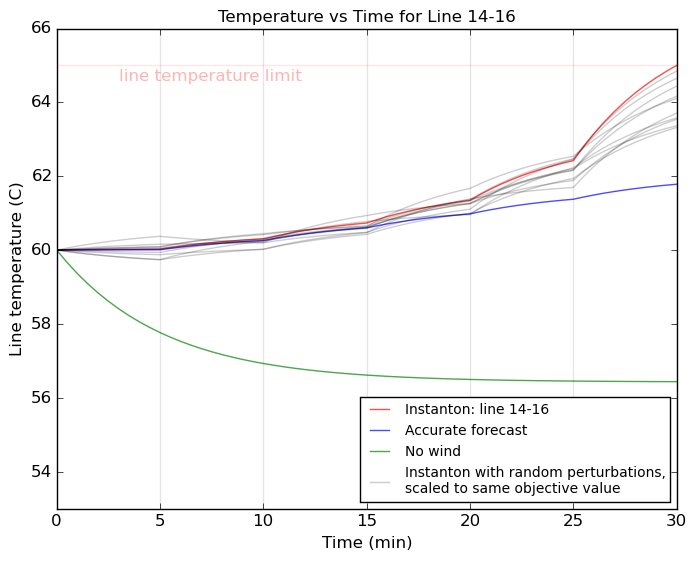

PyObject <matplotlib.text.Text object at 0x7f55c75fe550>

In [9]:
# Choose event index (1 is instanton):
eidx = 1

# System parameters:
n = length(k)
nr = length(Ridx)
T = convert(Int64,length(find(P0))/nr)

# Thermal parameters:
conductor_name = "waxwing"
cp = return_conductor_params(conductor_name)
Tlim = cp.Tlim
ηc = cp.ηc
ηr = cp.ηr
qs = cp.qs
mCp = cp.mCp
Tmid = (Tamb + Tlim)/2
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 10
vecs = Array(Vector,0)

# First vector is instanton analysis output:
tempVec = Array(FloatingPoint,0)
for i in 1:T
    append!(tempVec,x[idx][i])
end
push!(vecs,tempVec)

# Second vector represents accurate forecast:
push!(vecs,zeros(length(vecs[1])))

# Third vector cancels all wind gen:
push!(vecs,-P0[find(P0)])

# Add a family of vectors with same norm as
# instanton vector:
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(Nr*T) - 0.5).*(i+1)/35
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end

# Use power flow data and thermal model to compute
# temperature trajectories for each vector:
temp_trajectories = Array(Vector,0)
angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)
for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(T,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,N,T)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,N,T)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 60. #46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end
    push!(temp_trajectories,temp_values)
end

# Plot
fig = figure(figsize=(8,6))
xvals = (0:length(temp_trajectories[1])-1)*time_intervals*int_length/(60*(length(temp_trajectories[1])-1))
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(xvals,temp_trajectories[i],alpha=0.7,"r")
        elseif i == 2
        plot(xvals,temp_trajectories[i],alpha=0.7,"b")
        elseif i == 3
        plot(xvals,temp_trajectories[i],alpha=0.7,"g")
    else
        plot(xvals,temp_trajectories[i],alpha=0.2,"k")
    end
end
title("Temperature vs Time for Line $(from)-$(to)",fontsize=12)
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)",
    "Accurate forecast",    
    "No wind",
    "Instanton with random perturbations, \nscaled to same objective value"],fontsize=10,loc=4)
axis([0,30,53,66])
for i in 1:time_intervals
    xval = i*int_length/60
    plot([xval;xval],[40,1.1*Tlim],"k",alpha=0.1)
end
plot([0,30],[Tlim;Tlim],"r",alpha=0.1)
text(3,64.6,"line temperature limit",color="red",alpha=0.3)#color="#FFB2B2")

#savefig("../images/2015-06-24-trajectory_compare3.png", dpi=600)

## Problem

When I use only waxwing, everything works as it has for a while now. But when I use a mix of waxwing and dove, the results are nonsense. All the scores are higher! The same line with the same conductor parameters should not get a higher instanton score just because other lines have different parameters.

I need to debug this...